필요한 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
from keras import optimizers
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

C:\Q3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Q3\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Q3\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Q3\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of t

데이터 불러오기 & 전처리

In [2]:
data = pd.read_csv("MLB_2014_2017.csv")
data = data.drop(['Name', 'Id', 'Tm'], axis = 1)
data['Lg'] = data['Lg'].replace(['NL','MLB/NL','MLB/AL/NL'], 1)
data['Lg'] = data['Lg'].replace(['AL','MLB/AL','MLB/NL/AL'] ,0)

data = data.dropna()
data = data[data['Salary'] != 0]

data = data.astype(np.float32)
data['Salary'] = data['Salary']/10000

y_data = data['Salary']
x_data = data.drop(['Salary'], axis=1)

def norm(dataset):
    stats = dataset.describe()
    normed_dataset = (dataset - stats.mean())/(stats.std())
    return normed_dataset

normed_x_data = norm(x_data)

NN 분석을 위한 모델링

In [ ]:
model = models.Sequential()
model.add(layers.Dense(62, activation='relu', input_shape=(31,)))
model.add(layers.Dense(31, activation='relu'))
model.add(layers.Dense(1))

NN 모델 컴파일

In [ ]:
model.compile(loss='mse',optimizer='adam', metrics=['mae','mse'])

In [ ]:
NN 모델에 데이터 학습 

In [ ]:
history = model.fit(normed_x_data, y_data, epochs=100, batch_size=20, validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

NN 학습 History 시각화

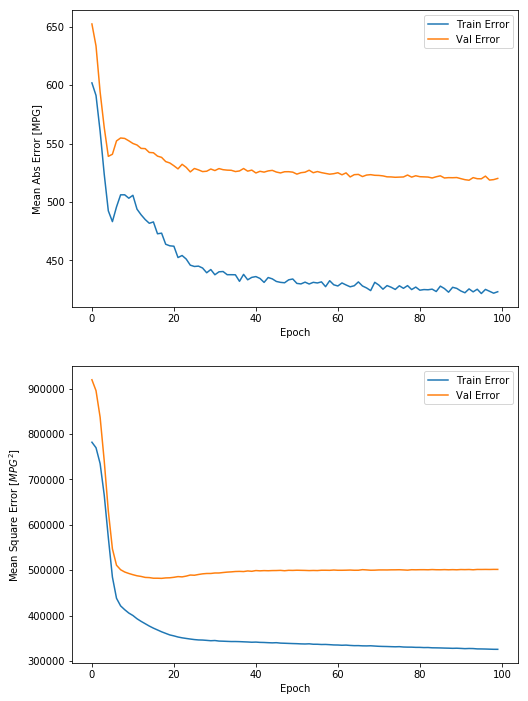

In [74]:
plt.figure(figsize=(8,12))

plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [MPG]')
plt.plot(hist['epoch'], hist['mean_absolute_error'],
       label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
       label = 'Val Error')
# plt.ylim([0,1])
plt.legend()

plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$MPG^2$]')
plt.plot(hist['epoch'], hist['mean_squared_error'],
       label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_squared_error'],
       label = 'Val Error')
# plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
학습한 모델을 통해 값 예측

In [ ]:
prediction_data = model.predict(normed_x_data)
p_data = pd.DataFrame(prediction_data)

# Sklearn의 R2Score 활용
print(r2_score(y_data, prediction_data))

In [ ]:
HyperParameter 최적화를 위한 세팅

In [75]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# KerasClassifier를 사용해서 변환해줘야 sklearn의 GridSearchCV와 호환됨
k_model = KerasClassifier(model, epochs=100, batch_size=10, verbose=0)

In [ ]:
GridSearchParameter 값 지정

In [76]:
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=k_model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
GridSearchCV를 통해 fitting 

In [77]:
grid_result = grid.fit(normed_x_data, y_data)

InvalidArgumentError: Node 'IsVariableInitialized_178/IsVariableInitialized_75/training_6/Adam/sub_2': Unknown input node 'IsVariableInitialized_178/IsVariableInitialized_75/training_6/Adam/sub_2/x'

In [ ]:
GridSearchCV 결과 리뷰

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.686198 using {'epochs': 100, 'batch_size': 20}
0.348958 (0.024774) with: {'epochs': 10, 'batch_size': 10}
0.348958 (0.024774) with: {'epochs': 50, 'batch_size': 10}
0.466146 (0.149269) with: {'epochs': 100, 'batch_size': 10}
0.647135 (0.021236) with: {'epochs': 10, 'batch_size': 20}
0.660156 (0.014616) with: {'epochs': 50, 'batch_size': 20}
0.686198 (0.024774) with: {'epochs': 100, 'batch_size': 20}
0.489583 (0.075566) with: {'epochs': 10, 'batch_size': 40}
0.652344 (0.019918) with: {'epochs': 50, 'batch_size': 40}
0.654948 (0.027866) with: {'epochs': 100, 'batch_size': 40}
0.518229 (0.032264) with: {'epochs': 10, 'batch_size': 60}
0.605469 (0.052213) with: {'epochs': 50, 'batch_size': 60}
0.665365 (0.004872) with: {'epochs': 100, 'batch_size': 60}
0.537760 (0.143537) with: {'epochs': 10, 'batch_size': 80}
0.591146 (0.094954) with: {'epochs': 50, 'batch_size': 80}
0.658854 (0.054904) with: {'epochs': 100, 'batch_size': 80}
0.402344 (0.107735) with: {'epochs': 10, 'batch_size': 100}
0.652344 (0.033299) with: {'epochs': 50, 'batch_size': 100}
0.542969 (0.157934) with: {'epochs': 100, 'batch_size': 100}